# Lab 4

In [106]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

df = pd.read_csv('chess_games.csv')

## 1. Закон распределения количества ходов

Обозначим через $X$ количество ходов в партии (`turns`). Сначала визуально исследуем распределение и подберём подходящий вероятностный закон. Затем проверим гипотезу о соответствии данных этому закону.

---

Перед началом тестов выполним дополнительное задание и проверим годится ли наша выборка для применения критериев, требуеющих простоту выборки. 

Проведём тест инверсий на $U_i = F(X_i, \hat{\mu}, \hat{\sigma})$ полученных через cdf $F$ логнормального распределения и оценку параментров по МПП.

$$ H'_0 : U_1 , \dots , U_n \; i.i.d \; \text{Uniform} (0, 1)$$
$$ H'_1 : \neg H'_1 $$

In [107]:
# 0.1 Тест инверсий для проверки простоты выборки относительно логнормальной модели

alpha = 0.05
X = df['turns'].dropna().values
n = len(X)
log_X = np.log(X)
mu_hat = np.mean(log_X)
sigma_hat = np.std(log_X, ddof=1)

U_full = stats.lognorm.cdf(X, s=sigma_hat, scale=np.exp(mu_hat))

def count_inversions(arr):
    def merge_sort(a):
        if len(a) <= 1:
            return a, 0
        mid = len(a) // 2
        left, inv_left = merge_sort(a[:mid])
        right, inv_right = merge_sort(a[mid:])
        merged, inv_split = merge(left, right)
        return merged, inv_left + inv_right + inv_split
    def merge(left, right):
        i = j = inv_count = 0
        merged = []
        while i < len(left) and j < len(right):
            if left[i] <= right[j]:
                merged.append(left[i])
                i += 1
            else:
                merged.append(right[j])
                inv_count += len(left) - i
                j += 1
        merged.extend(left[i:])
        merged.extend(right[j:])
        return merged, inv_count
    _, inv_count = merge_sort(arr)
    return inv_count

S_full = count_inversions(U_full)
\
E_S_full = n * (n - 1) / 4
Var_S_full = n * (n - 1) * (2 * n + 5) / 72
Z_full = (S_full - E_S_full) / np.sqrt(Var_S_full)
\
p_value_full = 2 * (1 - stats.norm.cdf(np.abs(Z_full)))

print(f'Тест инверсий: Z = {Z_full:.5f}, p-value = {p_value_full:.5f}')
if p_value_full < alpha:
    print('Вывод: rejected H_0.')
else:
    print('Вывод: accepted H_0.')

Тест инверсий: Z = -9.09112, p-value = 0.00000
Вывод: rejected H_0.


Очень жаль. Полномочия всё. Века выводов теории математической статистики не помогут нам узнать тайну шахмат.

Мы можем только погрустить и пойти дальше пробовать искать истину, применяя инструменты и имея то, что есть.

---

Количество партий: 20058
Минимум, максимум: 1 349


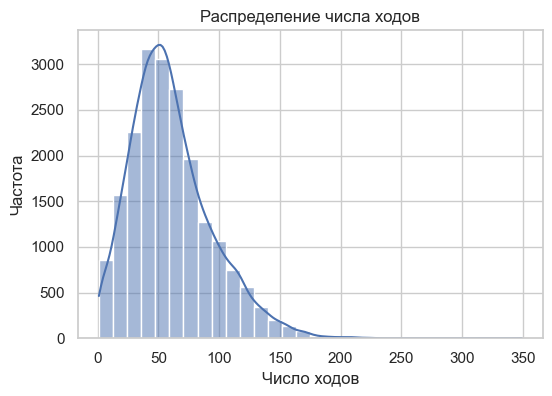

In [108]:
turns = df['turns'].dropna()
print('Количество партий:', len(turns))
print('Минимум, максимум:', turns.min(), turns.max())

plt.figure(figsize=(6, 4))
sns.histplot(turns, bins=30, kde=True)
plt.title('Распределение числа ходов')
plt.xlabel('Число ходов')
plt.ylabel('Частота')
plt.show()

График эмпирической функции распределения похож на логнормальное. Предположим что случайности случайны, тогда зафиксируем гипотезу по умолчанию:

$$H_0: X \sim LogN (\mu, \sigma^2)$$

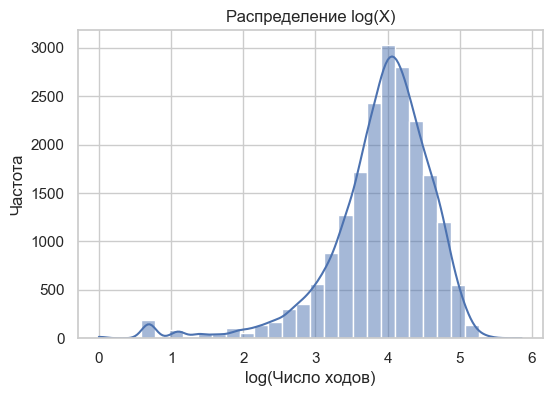

In [109]:
log_turns = np.log(turns)
plt.figure(figsize=(6, 4))
sns.histplot(log_turns, bins=30, kde=True)
plt.title('Распределение log(X)')
plt.xlabel('log(Число ходов)')
plt.ylabel('Частота')
plt.show()

Если $X$ имеет логнормальное распределение, тогда его логарифм соответсвует нормальному. На графике логарифмированной величины лучше видны артефакты эмпирического распределения, которые было труднее заметить исходно. Хвосты не симметричны и ведут себя неоднородно. Подозревается, что может быть выполнена альтернатива:

$$ H_1 : X \not\sim LogN (\mu, \sigma^2)$$

Будем работать с $\ln (X)$ и проверять нормальность данной величины. 

#### ks-test


> **Статистика критерия**

Строим эмпирическую функцию распределения $F_n(x)$, теоретическую $F(x;\hat\mu,\hat\sigma)$, и вычисляем:

$$
D_n = \sup_{x \in \mathbb{R}} \left| F_n(x) - F(x) \right|,
\quad
K_n = \sqrt{n} D_n
$$

где $n$ — объём выборки.

> **Критическая область**

Критическая область имеет вид:

$$
K_n > q_{1-\alpha}
$$

где $q_{1-\alpha}$ — табличное значение квантиля распределения Колмогорова для $\sqrt{n}D_n$.


> **p-value**

Приближённо:

$$
\text{p-value} = 2 \sum_{k=1}^{\infty} (-1)^{k-1} e^{-2k^2 K_n^2}
$$

In [110]:
# 1.1 Ручной критерий Колмогорова для логнормального распределения X

alpha = 0.05

X = turns.values
n = len(X)
log_X = np.log(X)

mu_hat = np.mean(log_X)
sigma_hat = np.std(log_X, ddof=1)

print(f'Оценки параметров: mu = {mu_hat:.3f}, sigma = {sigma_hat:.3f}\n')

X_sorted = np.sort(X)
F_n = np.arange(1, n + 1) / n
F_theor = stats.lognorm.cdf(X_sorted, s=sigma_hat, scale=np.exp(mu_hat))

D_n = np.max(np.abs(F_n - F_theor))
K_n = np.sqrt(n) * D_n

print(f'D_n = {D_n:.5f}')
print(f'K_n = {K_n:.5f}')

q_alpha = stats.kstwobign.ppf(1 - alpha)
print(f'q_(1-alpha) = {q_alpha:.5f}')

def kolmogorov_pvalue(Kn, terms=100):
    s = 0.0
    for k in range(1, terms + 1):
        s += (-1)**(k - 1) * np.exp(-2 * (k * Kn) ** 2)
    return 2 * s

p_value_K = kolmogorov_pvalue(K_n)
print(f'p-value ≈ {p_value_K:.5f}\n')

if K_n > q_alpha:
    print('Результат: rejected H_0.')
else:
    print('Результат: accepted H_0.')

Оценки параметров: mu = 3.907, sigma = 0.721

D_n = 0.09963
K_n = 14.10959
q_(1-alpha) = 1.35810
p-value ≈ 0.00000

Результат: rejected H_0.


#### Shapiro-Wilk test

ks-тест обладает своими недостатками в плане теста на нормальность, так что проведём второй статтест, который более предпочтителен в контексте исследования нормальности -- критерий Шапиро-Уилка. 

Воспользуемся встроенной функцией модуля `scipy.stats`.


> **Статистика теста**

Тест Шапиро–Уилка основан на статистике:

$$
W = \frac{\left( \sum_{i=1}^n a_i x_{(i)} \right)^2}{\sum_{i=1}^n (x_i - \bar{x})^2}
$$

где:
- $x_{(i)}$ — упорядоченные логарифмированные наблюдения,
- $\bar{x}$ — среднее значение логарифмированных данных,
- $a_i$ — специальные веса, зависящие от выборочного размера $n$ и предполагаемой нормальности.


> **Происхождение весов $a_i$ в критерии Шапиро–Уилка**

Весовые коэффициенты $a_i$ в статистике

$$
W = \frac{\left( \sum_{i=1}^n a_i\,x_{(i)} \right)^2}{\sum_{i=1}^n (x_i - \bar{x})^2}
$$

выбираются так, чтобы максимально «выжать» из выборки информацию об отклонении от нормальности.  

Конкретнее:

1. **Стандартные нормальные порядковые статистики.**  
   Обозначим через
   $$
     z_{(1)} < z_{(2)} < \cdots < z_{(n)}
   $$
   упорядоченные наблюдения из выборки размера $n$, взятые из стандартного нормального распределения $\mathcal{N}(0,1)$.

2. **Вектор ожидаемых значений.**  
   Построим вектор
   $$
     \mathbf{m} = \bigl( m_1, m_2, \dots, m_n \bigr)^\top,
     \quad
     m_i = \mathbb{E}\bigl[z_{(i)}\bigr]
   $$

3. **Ковариационная матрица.**  
   Пусть
   $$
     \mathbf{V} = \bigl[\,\operatorname{Cov}\bigl(z_{(i)}, z_{(j)}\bigr)\bigr]_{i,j=1}^n
   $$
   — матрица ковариаций порядковых статистик из $\mathcal{N}(0,1)$.

4. **Вычисление весов.**  
   Тогда «оптимальные» веса получаются из решения задачи максимизации отношения квадратов:
   $$
     a_i \propto \sum_{j=1}^n \bigl(\mathbf{V}^{-1}\bigr)_{ij}\,m_j
   $$
   с нормировкой
   $$
     \sum_{i=1}^n a_i\,m_i = 1
   $$
   В векторной форме запись такая:
   $$
     \mathbf{a}
     =
     \frac{\mathbf{V}^{-1}\,\mathbf{m}}
          {\sqrt{\mathbf{m}^\top\,\mathbf{V}^{-1}\,\mathbf{V}^{-1}\,\mathbf{m}}}
     \quad\Longrightarrow\quad
     \sum_i a_i\,m_i = 1
   $$

5. **Практическая реализация.**  
   На практике значения $\mathbf{m}$ и $\mathbf{V}$ вычисляются однократно (или аппроксимируются полиномами от $n$ и хранятся в таблицах или «жестко» кодированы в статистических пакетах.  


In [111]:
# 1.2 Критерий Шапиро–Уилка

shapiro_stat, shapiro_p = stats.shapiro(log_turns.sample(len(log_turns), random_state=0))
print(f'Статистика Шапиро–Уилка: {shapiro_stat:.3f}')
print(f'p-value: {shapiro_p:.4f}')

if shapiro_p < alpha:
    print('Результат: rejected H0.')
else:
    print('Результат: accepted H0.')

Статистика Шапиро–Уилка: 0.894
p-value: 0.0000
Результат: rejected H0.


C:\Users\Admin\AppData\Roaming\Python\Python312\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 20058.
  res = hypotest_fun_out(*samples, **kwds)


Выборка большая и ожидаемо для критерия Шапиро-Уилка мы получили уведомление о размере. Но так или иначе результат сходится с критерием Колмогорова.

### Вывод

Взгляд инопланетянина показал, что распределение не логнормальное, хоть наши глаза и опыт говорят о другом.

Однако если проредить выборку, причесать её, убрав, хоть и натурально полученные, выбросы, инопланетяне почти наверное тоже скажут, что распределение логнормальное, что подтверждает то, как надо относиться к гипотезам $H_0$ и $H_1$.

## 2. Сравнение распределения ходов в рейтинговых и нерейтинговых играх

Теперь в данном блоке пусть $X$ -- число ходов в рейтинговых играх, а $Y$ -- нерейтинговых.

Проверим, что распределение этих выборок одно и то же.

$$ H_0 : F_X = F_Y$$

$$ H_1 : F_X \not = F_Y $$

--- 

Перед началом анализа, выполним аналогичное первому блоку дополнительное задание: Убедимся, что эта пара выборок независима.

Воспользуемся ранговым тестом -- Спирмана.

Гипотезы для выборочного коэффициента корреляции Спирамана $\rho$:

$$ H'_0 : \rho = 0 \; (\text{независимость распределений})$$

$$ H'_1 : \rho \not = 0  \; (\text{зависимость распределений})$$

In [112]:
rated_mask = (df['rated'] == True) | (df['rated'].astype(str).str.lower() == 'true')
turns_rated = df.loc[rated_mask, 'turns'].dropna()
turns_unrated = df.loc[~rated_mask, 'turns'].dropna()

print('Рейтинговых партий:', len(turns_rated))
print('Нерейтинговых партий:', len(turns_unrated))

def spearman_test_two_sided(x, y):
    n = len(x)
    R = np.argsort(np.argsort(x)) + 1
    S = np.argsort(np.argsort(y)) + 1
    numerator = np.sum((R - (n + 1) / 2) * (S - (n + 1) / 2))
    rho = 12 * numerator / (n * (n**2 - 1))
    Z = np.sqrt(n) * rho
    p_value = 2 * (1 - stats.norm.cdf(abs(Z)))
    return rho, Z, p_value

n_eq = min(len(turns_rated), len(turns_unrated))
sr = turns_rated.values[:n_eq]
su = turns_unrated.values[:n_eq]
rho_sp, Z_sp, p_sp = spearman_test_two_sided(sr, su)

print(f'Тест Спирмена: rho = {rho_sp:.5f}, Z = {Z_sp:.5f}, p-value = {p_sp:.5f}')
if p_sp < 0.05:
    print('Результат: rejected H_0.')
else:
    print('Результат: accepted H_0.')


Рейтинговых партий: 16155
Нерейтинговых партий: 3903
Тест Спирмена: rho = 0.00377, Z = 0.23578, p-value = 0.81360
Результат: accepted H_0.


Оснований считать что $H'_0$ ложно нет. Со спокойной душой идём применять выборку в теоремах для решения задачи далее.

---

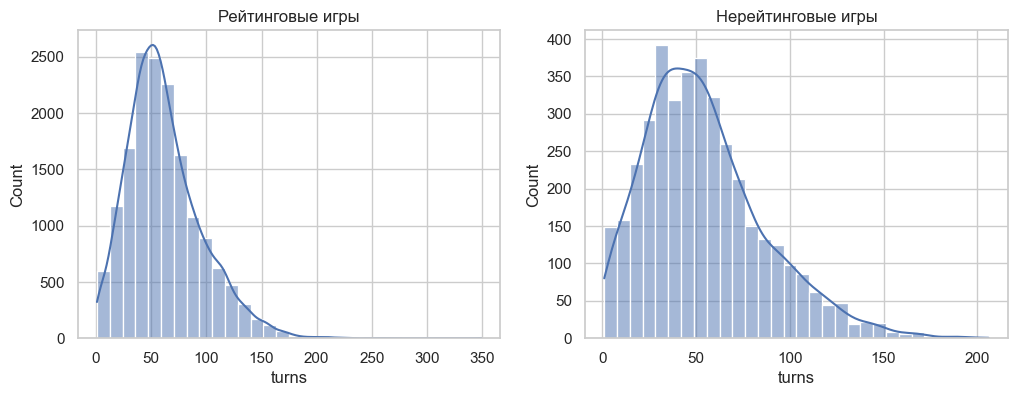

In [113]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.histplot(turns_rated, bins=30, kde=True, ax=axes[0])
axes[0].set_title('Рейтинговые игры')
sns.histplot(turns_unrated, bins=30, kde=True, ax=axes[1])
axes[1].set_title('Нерейтинговые игры')
plt.show()

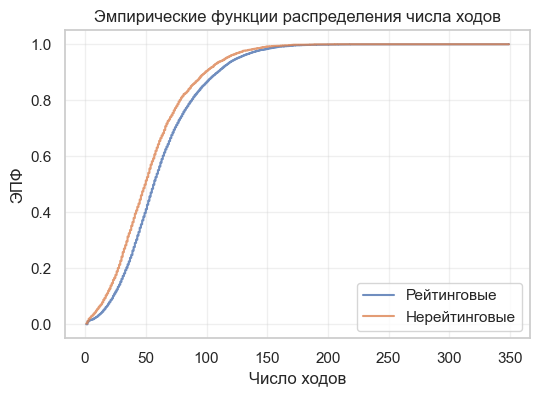

In [114]:
x_vals = np.sort(np.concatenate([turns_rated.values, turns_unrated.values]))
ecdf_rated = np.searchsorted(np.sort(turns_rated.values), x_vals, side='right') / len(turns_rated)
ecdf_unrated = np.searchsorted(np.sort(turns_unrated.values), x_vals, side='right') / len(turns_unrated)

plt.figure(figsize=(6, 4))
plt.step(x_vals, ecdf_rated, where='post', label='Рейтинговые', alpha=0.8)
plt.step(x_vals, ecdf_unrated, where='post', label='Нерейтинговые', alpha=0.8)
plt.xlabel('Число ходов')
plt.ylabel('ЭПФ')
plt.title('Эмпирические функции распределения числа ходов')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

#### ks-test


> **Статистика критерия**

Статистика теста Смирнова для двух выборок с размерами $m$ и $n$:

$$
D_{mn} = \sup_{x \in \mathbb{R}} \left| F_1(x) - F_2(x) \right|
$$

Нормированная статистика:

$$
K_{mn} = \sqrt{\frac{mn}{m+n}} D_{mn}
$$

где $m$ и $n$ — размеры выборок.


> **Критическая область**

Для уровня значимости $1 - \alpha$:

$$
K_{mn} > q_{1-\alpha}
$$

где $q_{1-\alpha}$ — квантиль распределения для статистики Смирнова на уровне $1 - \alpha$.


> **p-value**

p-value можно вычислить как вероятность того, что статистика $K_{mn}$ будет больше наблюдаемого значения при $H_0$.


In [115]:
# 2.1 Ручной критерий: тест Смирнова на однородность распределений

alpha = 0.05

x = np.array(turns_rated)
y = np.array(turns_unrated)

m = len(x)
n = len(y)
print('Размер выборки (рейтинговые):', m)
print('Размер выборки (нерейтинговые):', n)
print('\n')

all_vals = np.sort(np.concatenate([x, y]))

F1 = np.searchsorted(np.sort(x), all_vals, side='right') / m
F2 = np.searchsorted(np.sort(y), all_vals, side='right') / n

D_mn = np.max(np.abs(F1 - F2))
K_mn = np.sqrt(m * n / (m + n)) * D_mn

print(f'D_mn = {D_mn:.5f}')
print(f'K_mn = {K_mn:.5f}')

q_alpha = stats.kstwobign.ppf(1 - alpha)
print(f'q_(1-alpha) = {q_alpha:.5f}')

def kolmogorov_pvalue(Kn, terms=100):
    s = 0.0
    for k in range(1, terms + 1):
        s += (-1)**(k - 1) * np.exp(-2 * (k * Kn) ** 2)
    return 2 * s

p_value_smirnov = kolmogorov_pvalue(K_mn)
print(f'p-value ≈ {p_value_smirnov:.5f}\n')

if K_mn > q_alpha:
    print('Результат: rejected H0.')
else:
    print('Результат: accepted H0.')

Размер выборки (рейтинговые): 16155
Размер выборки (нерейтинговые): 3903


D_mn = 0.10440
K_mn = 5.85323
q_(1-alpha) = 1.35810
p-value ≈ 0.00000

Результат: rejected H0.


#### Mann-Whitney-Wilcoxon test

Проведём второй тест для подтвеждения результатов первого. В этот раз применим ранговый критерий Манна-Уитни-Вилкоксона. Воспользуемся встроенной функцией модуля `scipy.stats`.


> **Формулировка гипотез**  
$$
H_0: F_1(x) = F_2(x) 
$$
$$ H_1: F_1(x)\neq F_2(x) $$

> **Статистика Манна–Уитни-Вилкоксона**  

1. Объединяем выборки $X=\{X_i\}_{i=1}^m$ и $Y=\{Y_j\}_{j=1}^n$, присваиваем ранги $R_k$ всем $m+n$ наблюдениям.  
2. Сумма рангов первой выборки:
$$
T = \sum_{i=1}^m R(X_i)
$$
3. Альтернативная форма (Манна–Уитни):
$$
U = \sum_{i=1}^m \sum_{j=1}^n \mathbf{1}\{X_i<Y_j\}
$$
Они связаны:
$$
T + U = m n + \frac{m(m+1)}{2}
$$


> **Критическая область**  
Для уровня $1- \alpha$:
$$
T \le T_{\alpha}(m,n)\quad\text{или}\quad U \le U_{\alpha}(m,n)
$$

> **p-value**  
Через нормальное приближение для больших $m,n$:
$$
\mu_U = \frac{mn}{2},\quad \sigma_U = \sqrt{\frac{mn(m+n+1)}{12}},
\quad Z = \frac{U - \mu_U}{\sigma_U}
$$
p-value = $2\bigl(1 - \Phi(|Z|)\bigr)$


In [116]:
# 2.2 Готовый критерий: Манн-Уитни из scipy.stats
mw_stat, mw_p = stats.mannwhitneyu(turns_rated, turns_unrated, alternative='two-sided')
print(f'Статистика Манна–Уитни (scipy): {mw_stat:.2f}')
print(f'p-value: {mw_p:.4f}')

if mw_p < alpha:
    print('Результат: rejected H0.')
else:
    print('Результат: accepted H0.')

Статистика Манна–Уитни (scipy): 35921399.50
p-value: 0.0000
Результат: rejected H0.


### Вывод
Cкорее всего в рейтинговых играх люди более упорно играют на победу несмотря ни на что, что увеличивает число ходов.

## 3. Связь количества ходов с разницей рейтинга

Проверим отрицательную монотонную зависимость между числом ходов и разницей рейтинга.

#### Spierman test

Определяем коэффициент Спирмена как:

$$
\rho = \frac{12}{n(n^2-1)} \sum_{i=1}^{n} \left(R_i - \frac{n+1}{2}\right)\left(S_i - \frac{n+1}{2}\right)
$$

где $R_i$ и $S_i$ — ранги переменных $X$ и $Y$ соответственно.

> **Гипотезы**

$$
H_0: \rho = 0 \quad (\text{нет монотонной зависимости})
$$

$$
H_1: \rho < 0 \quad (\text{существует отрицательная монотонная зависимость})
$$


> **Асимптотическое распределение**

Под гипотезой $H_0$ (и при достаточно большом $n$):

$$
\sqrt{n}\,\rho \xrightarrow{d} \mathcal{N}(0,1)
$$

То есть приблизительно

$$
Z = \sqrt{n}\,\rho \sim \mathcal{N}(0,1)
$$

> **Критическая область**

Так как альтернатива левосторонняя ($H_1: \rho < 0$), критическая область для уровня значимости $\alpha$ имеет вид

$$
Z < z_{\alpha}
$$

где $z_{\alpha}$ — левый квантиль стандартного нормального распределения: $\Phi(z_{\alpha}) = \alpha$.


> **p-value и правило принятия решения**

Поскольку область односторонняя влево, p-value вычисляется как

$$
\text{p-value}
= \mathbb{P}(Z \le z_{\text{obs}})
= \Phi(z_{\text{obs}})
$$

где $z_{\text{obs}}$ — наблюдаемое значение Z-статистики, а $\Phi$ — cdf $\mathcal{N}(0,1)$.

**Правило принятия решения** при уровне значимости $\alpha$::

- Если $\text{p-value} < \alpha$ (или эквивалентно $z_{\text{obs}} < z_{\alpha}$), то **гипотеза $H_0$ отвергается в пользу $H_1$**.
- Иначе — **нет оснований отвергнуть $H_0$**.



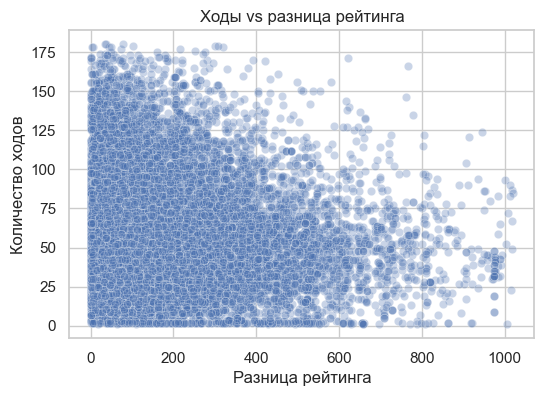

In [117]:
df_sub = df[['turns', 'white_rating', 'black_rating']].dropna()
df_sub = df_sub.copy()
df_sub['rating_diff'] = (df_sub['white_rating'] - df_sub['black_rating']).abs()

turns_vals = df_sub['turns'].values
diff_vals = df_sub['rating_diff'].values

low_turns, high_turns = np.quantile(turns_vals, [0.0005, 0.9975])
low_diff,  high_diff  = np.quantile(diff_vals,   [0.0005, 0.9975])

mask_trim = (
    (turns_vals >= low_turns) & (turns_vals <= high_turns) &
    (diff_vals  >= low_diff)  & (diff_vals  <= high_diff)
 )

df_trimmed = df_sub[mask_trim]

turns_corr = df_trimmed['turns']
diff = df_trimmed['rating_diff']

plt.figure(figsize=(6, 4))
sns.scatterplot(x='rating_diff', y='turns', data=df_trimmed, alpha=0.3)
plt.xlabel('Разница рейтинга')
plt.ylabel('Количество ходов')
plt.title('Ходы vs разница рейтинга')
plt.show()

In [118]:
# 3.1 Ручной расчёт коэффициента корреляции Спирмена и Z-критерия

alpha = 0.05
x = diff.values.astype(float)
y = turns_corr.values.astype(float)
n = len(x)

R = np.argsort(np.argsort(x)) + 1
S = np.argsort(np.argsort(y)) + 1

numerator = np.sum((R - (n + 1) / 2) * (S - (n + 1) / 2))
rho_hat = 12 * numerator / (n * (n**2 - 1))

Z = np.sqrt(n) * rho_hat

p_one_sided = stats.norm.cdf(Z)

print(f'Число наблюдений n = {n}')
print(f'Оценка коэффициента Спирмена rho_hat = {rho_hat:.4f}')
print(f'Z-статистика = {Z:.4f}')
print(f'p-value (одностороннее, H1: rho < 0) = {p_one_sided:.4f}')

if p_one_sided < alpha and rho_hat < 0:
    print('Результат: rejected H0.')
else:
    print('Результат: accepted H0.')

Число наблюдений n = 19956
Оценка коэффициента Спирмена rho_hat = -0.1131
Z-статистика = -15.9827
p-value (одностороннее, H1: rho < 0) = 0.0000
Результат: rejected H0.


#### Kendall test

Определяем коэффициент ранговой корреляции Кендалла как:

$$
\tau = \frac{2}{n(n-1)} \sum_{1 \leq i < j \leq n} \operatorname{sign}(T_j - T_i)
$$

где $T_i$ — вторая компонента пары $(R_i, S_i)$ после сортировки по $R_i$.


> **Гипотезы**

$$
H_0: \tau = 0 \quad (\text{нет монотонной зависимости})
$$

$$
H_1: \tau < 0 \quad (\text{существует отрицательная монотонная зависимость})
$$


> **Асимптотическое распределение**

Под гипотезой $H_0$ (и при достаточно большом $n$):

$$
\tau \sim \mathcal{N}\!\left(0,\,\frac{2(2n+5)}{9n(n-1)}\right)
$$

Переход к Z-статистике:

$$
Z = \frac{\tau}{\sqrt{\frac{2(2n+5)}{9n(n-1)}}}
\;\sim\;\mathcal{N}(0,1)
$$


> **Критическая область**

Так как альтернатива левосторонняя ($H_1: \tau < 0$), критическая область для уровня значимости $\alpha$ имеет вид

$$
Z < z_{\alpha}
$$

где $z_{\alpha}$ — левый квантиль стандартного нормального распределения: $\Phi(z_{\alpha}) = \alpha$.


> **p-value и правило принятия решения**

Поскольку область односторонняя влево, p-value вычисляется как

$$
\text{p-value}
= \mathbb{P}\bigl(Z \le z_{\text{obs}}\bigr)
= \Phi(z_{\text{obs}})
$$

где $z_{\text{obs}}$ — наблюдаемое значение Z-статистики, а $\Phi$ — cdf $\mathcal{N}(0,1)$.

**Правило принятия решения** при уровне значимости $\alpha$::

- Если $\text{p-value} < \alpha$ (или эквивалентно $z_{\text{obs}} < z_{\alpha}$), то **гипотеза $H_0$ отвергается в пользу $H_1$**.
- Иначе — **нет оснований отвергнуть $H_0$**.



In [119]:
# 3.2 Готовый критерий: коэффициент Кендалла (scipy) как проверка

tau_scipy, p_two_sided_scipy = stats.kendalltau(diff, turns_corr)

if tau_scipy < 0:
    p_one_sided_scipy = p_two_sided_scipy / 2
else:
    p_one_sided_scipy = 1 - p_two_sided_scipy / 2

print(f'Число наблюдений n = {len(diff)}')
print(f'Оценка коэффициента Кендалла tau_hat = {tau_scipy:.4f}')
print(f'p-value (двустороннее) = {p_two_sided_scipy:.4f}')
print(f'p-value (одностороннее) = {p_one_sided_scipy:.4f}')

if p_one_sided_scipy < alpha and tau_scipy < 0:
    print('Результат: rejected H0.')
else:
    print('Результат: accepted H0.')

Число наблюдений n = 19956
Оценка коэффициента Кендалла tau_hat = -0.0756
p-value (двустороннее) = 0.0000
p-value (одностороннее) = 0.0000
Результат: rejected H0.


#### Вывод
Cильный игрок быстрее ставит мат слабому.